In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.utilities  import signal_power
from commpy.modulation import QAMModem

from utils.dsp import pulseShape, firFilter, edc, cpr #, fourthPowerFOE, dbp, cpr
from utils.models import phaseNoise, pdmCoherentReceiver#, manakovSSF
from utils.modelsGPU import manakovSSF
from utils.tx import simpleWDMTx
from utils.core import parameters
from utils.equalization import mimoAdaptEqualizer
from utils.metrics import fastBERcalc, monteCarloGMI

from scipy import signal
import scipy.constants as const

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [4]:
%load_ext autoreload
%autoreload 2

# Simulation of coherent WDM systems

## Coherent WDM system

### Transmitter

In [5]:
help(simpleWDMTx)

Help on function simpleWDMTx in module utils.tx:

simpleWDMTx(param)
    Simple WDM transmitter
    
    Generates a complex baseband waveform representing a WDM signal with arbitrary number of carriers
    
    :param.M: QAM order [default: 16]
    :param.Rs: carrier baud rate [baud][default: 32e9]
    :param.SpS: samples per symbol [default: 16]
    :param.Nbits: total number of bits per carrier [default: 60000]
    :param.pulse: pulse shape ['nrz', 'rrc'][default: 'rrc']
    :param.Ntaps: number of coefficients of the rrc filter [default: 4096]
    :param.alphaRRC: rolloff do rrc filter [default: 0.01]
    :param.Pch_dBm: launched power per WDM channel [dBm][default:-3 dBm]
    :param.Nch: number of WDM channels [default: 5]
    :param.Fc: central frequency of the WDM spectrum [Hz][default: 193.1e12 Hz]
    :param.freqSpac: frequency spacing of the WDM grid [Hz][default: 40e9 Hz]
    :param.Nmodes: number of polarization modes [default: 1]



In [6]:
help(manakovSSF)

Help on function manakovSSF in module utils.modelsGPU:

manakovSSF(Ei, Fs, paramCh)
    Manakov model split-step Fourier (symmetric, dual-pol.)
    
    :param Ei: input signal
    :param Fs: sampling frequency of Ei [Hz]
    :param paramCh: object with physical parameters of the optical channel
    
    :paramCh.Ltotal: total fiber length [km][default: 400 km]
    :paramCh.Lspan: span length [km][default: 80 km]
    :paramCh.hz: step-size for the split-step Fourier method [km][default: 0.5 km]
    :paramCh.alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    :paramCh.D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    :paramCh.gamma: fiber nonlinear parameter [1/W/km][default: 1.3 1/W/km]
    :paramCh.Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    :paramCh.amp: 'edfa', 'ideal', or 'None. [default:'edfa']
    :paramCh.NF: edfa noise figure [dB] [default: 4.5 dB]    
    
    :return Ech: propagated signal



## Polarization multiplexed WDM signal

**signal generation**

In [7]:
# Parâmetros do transmissor:
param = parameters()
param.M   = 64           # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 8            # número de amostras por símbolo
param.Nbits = 600000     # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = 1        # potência média por canal WDM [dBm]
param.Nch     = 5        # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 40e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 2         # número de modos de polarização

sigWDM_Tx, symbTx_, param = simpleWDMTx(param)

freqGrid = param.freqGrid

Mode #0
channel 1 power : -2.01 dBm, fc : 193.0200 THz
channel 2 power : -2.01 dBm, fc : 193.0600 THz
channel 3 power : -2.01 dBm, fc : 193.1000 THz
channel 4 power : -2.01 dBm, fc : 193.1400 THz
channel 5 power : -2.01 dBm, fc : 193.1800 THz
Mode #1
channel 1 power : -2.01 dBm, fc : 193.0200 THz
channel 2 power : -2.01 dBm, fc : 193.0600 THz
channel 3 power : -2.01 dBm, fc : 193.1000 THz
channel 4 power : -2.01 dBm, fc : 193.1400 THz
channel 5 power : -2.01 dBm, fc : 193.1800 THz
total WDM signal power: 7.99 dBm


**Nonlinear fiber propagation with the split-step Fourier method**

In [8]:
linearChannel = False

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 800   # km
paramCh.Lspan  = 80    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.hz = 0.5       # km
paramCh.gamma = 1.3    # 1/(W.km)

if linearChannel:
    paramCh.hz = paramCh.Lspan 
    paramCh.gamma = 0  

Fs = param.Rs*param.SpS
sigWDM, paramCh = manakovSSF(sigWDM_Tx, Fs, paramCh) 


receivedSignal = sigWDM.copy()
transmSymbols  = symbTx_.copy()

In [9]:
#%lprun -f manakovSSF manakovSSF(sigWDM_Tx, Fs, paramCh)

**Optical WDM spectrum before and after transmission**

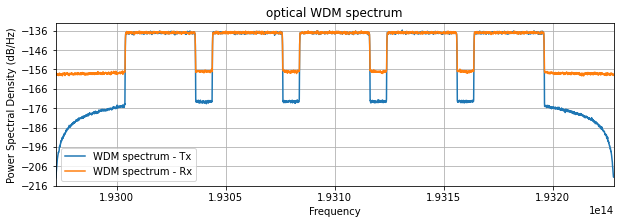

In [10]:
# plot psd
plt.figure()
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

**WDM channels coherent detection and demodulation**

Demodulating channel #2 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 10.00 kHz, FO: 0.00 MHz



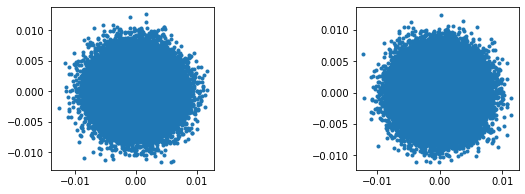

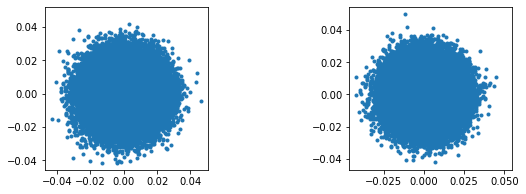

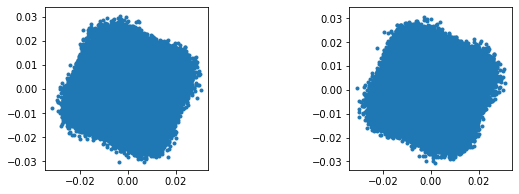

In [11]:
### Receiver

# parameters
chIndex  = 2    # index of the channel to be demodulated
plotPSD  = True

Fa = param.SpS*param.Rs
Fc = paramCh.Fc
Ta = 1/Fa
mod = QAMModem(m=param.M)

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = transmSymbols[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 0*64e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 10e3                  # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig = π/3, Rdx=1, Rdy=1)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

# Rx filtering

# Matched filter
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

# CD compensation
sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fa)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

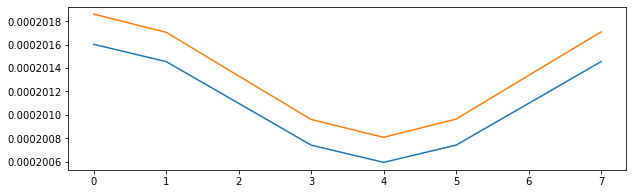

In [12]:
# simple timing recovery
sampDelay = np.zeros(sigRx.shape[1])
for k in range(0, sigRx.shape[1]):
    a = sigRx[:,k].reshape(sigRx.shape[0],1)
    varVector = np.var(a.reshape(-1,param.SpS), axis=0) # finds best sampling instant
    plt.plot(varVector)
    sampDelay[k] = np.where(varVector == np.amax(varVector))[0][0]

# downsampling
sigRx_ = sigRx[::int(param.SpS/2),:]
for k in range(0, sigRx.shape[1]):
    sigRx_[:,k] = sigRx[int(sampDelay[k])::int(param.SpS/2),k]

sigRx = sigRx_

In [13]:
# calculate time delay due to walkoff

symbDelay = np.zeros(sigRx.shape[1])
for k in range(0, sigRx.shape[1]):
    symbDelay[k] = np.argmax(signal.correlate(np.abs(symbTx[:,k]), np.abs(sigRx[::2,k])))-symbTx.shape[0]+1
    print(symbDelay[k])

# compensate walkoff time delay
for k in range(len(symbDelay)):    
    symbTx[:,k] = np.roll(symbTx[:,k], -int(symbDelay[k]))

0.0
0.0


In [14]:
#from numpy.matlib import repmat
#from tqdm.notebook import tqdm

x = sigRx
d = symbTx

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

#θ = np.pi/3

#rot = np.array([[np.cos(θ), -np.sin(θ)],[np.sin(θ), np.cos(θ)]])

#x = x@rot



nlms - training stage #0


nlms pre-convergence training iteration #0
nlms MSE = 0.058786.
nlms pre-convergence training iteration #1
nlms MSE = 0.020975.
nlms pre-convergence training iteration #2
nlms MSE = 0.020961.
nlms pre-convergence training iteration #3
nlms MSE = 0.020947.
nlms pre-convergence training iteration #4
nlms MSE = 0.020934.



nlms - training stage #1
nlms MSE = 0.017774.


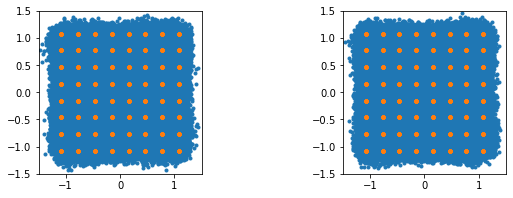

In [15]:
M = 64
mod = QAMModem(m=M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [5e-3, 5e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['nlms','nlms']
paramEq.M     = M
paramEq.L = [40000, 60000]

# from numpy.matlib import repmat
# y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(np.matlib.repmat(x,1,3),\
#                                            dx=np.matlib.repmat(d,1,3),\
#                                             paramEq=paramEq)

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1000

ax1.plot(y_EQ[discard:-discard,0].real, y_EQ[discard:-discard,0].imag,'.')
ax1.plot(d[:,0].real, d[:,0].imag,'.')
ax1.axis('square')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(y_EQ[discard:-discard,1].real, y_EQ[discard:-discard,1].imag,'.')
ax2.plot(d[:,1].real, d[:,1].imag,'.')
ax2.axis('square')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5);

     pol.X     pol.Y      
SER: 1.63e-01, 1.58e-01
BER: 4.39e-02, 4.23e-02
SNR: 17.70 dB, 17.79 dB
GMI: 5.03 bits, 5.06 bits


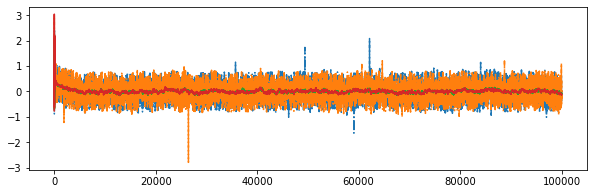

In [16]:
#constSymb  = mod.constellation/np.sqrt(mod.Es)
#y_CPR, ϕ, θ = cpr(y_EQ, 80, M, np.matlib.repmat(d,1,3), pilotInd=np.arange(0,len(y_EQ), 50))
y_CPR, ϕ, θ = cpr(y_EQ, 80, M, d, pilotInd=np.arange(0,len(y_EQ), 20))

plt.plot(ϕ,'-.', θ,'-')

discard = 2000
ind = np.arange(discard, d.shape[0]-discard)

# BER, SER, SNR = fastBERcalc(y_CPR[ind,:], np.matlib.repmat(d[ind,:],1,3), mod)
# GMI,_    = monteCarloGMI(y_CPR[ind,:], np.matlib.repmat(d[ind,:],1,3), mod)

BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], mod)
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], mod)

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

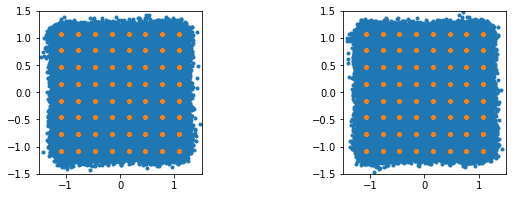

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1000

ax1.plot(y_CPR[discard:-discard,0].real, y_CPR[discard:-discard,0].imag,'.')
ax1.plot(d[:,0].real, d[:,0].imag,'.')
ax1.axis('square')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(y_CPR[discard:-discard,1].real, y_CPR[discard:-discard,1].imag,'.')
ax2.plot(d[:,1].real, d[:,1].imag,'.')
ax2.axis('square')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5);

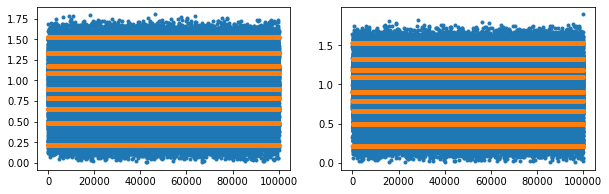

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1

ax1.plot(np.abs(y_EQ[discard:-discard,0]),'.')
ax1.plot(np.abs(d[:,0]),'.');
#ax1.axis('square')
#ax1.set_xlim(-1.5, 1.5)
#ax1.set_ylim(-1.5, 1.5)

ax2.plot(np.abs(y_EQ[discard:-discard,1]),'.')
ax2.plot(np.abs(d[:,1]),'.');
#ax2.axis('square')
#ax2.set_xlim(-1.5, 1.5)
#ax2.set_ylim(-1.5, 1.5);

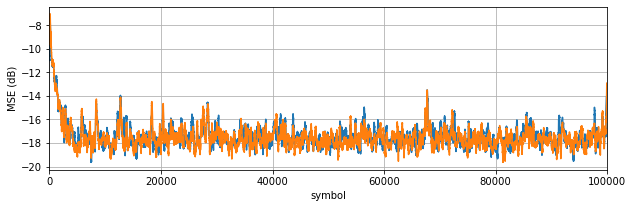

In [19]:
Nav = 200
h = np.ones(Nav)/Nav

plt.figure()
for ind in range(0, errSq.shape[0]):
    err_ = errSq[ind,:]
    plt.plot(10*np.log10(firFilter(h, err_)));
    
# for ind in range(0, errSq.shape[0]):
#     err_ = errSq[ind,:]
#     plt.plot(10*np.log10(np.convolve(h, err_)));

plt.grid()
plt.xlim(0,errSq.shape[1])
plt.xlabel('symbol')
plt.ylabel('MSE (dB)');

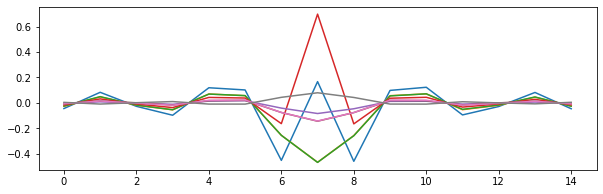

In [20]:
plt.plot(H.real.T,'-');
plt.plot(H.imag.T,'-');

# plt.stem(H[0,:].real.T,linefmt='r');
# plt.stem(H[3,:].imag.T,linefmt='b');

In [21]:
#%load_ext autoreload
#%autoreload 2

In [22]:
%load_ext line_profiler

In [23]:
#%lprun -f monteCarloGMI monteCarloGMI(y_EQ[ind,:], d[ind,:], mod)

In [24]:
#%lprun -f fastBERcalc fastBERcalc(y_EQ[ind,:], d[ind,:], mod)

In [25]:
#%lprun -f cpr cpr(y_EQ, 25, constSymb, d, pilotInd=np.arange(0,len(y_EQ), 50))

In [26]:
#!pip install --upgrade numba --user

In [27]:
#!pip install line_profiler